In [1]:
from plancklens import utils

import camb
from camb import model, initialpower
import numpy as np
import matplotlib.pyplot as plt

import healpy as hp

In [2]:
from os.path import join as opj
import os
from plancklens import utils

cls_path = opj(os.environ['HOME'], 'jointmap', 'data')
#cls_path = opj("/Users/omard/Downloads/", 'giulio')
cls_unl = utils.camb_clfile(opj(cls_path, 'lensedCMB_dmn1_lenspotentialCls.dat'))
cls_len = utils.camb_clfile(opj(cls_path, 'lensedCMB_dmn1_lensedCls.dat'))

HOME = os.environ['HOME']
tau_dir = opj(HOME, 'jointmap', 'data', 'tau_lensing_data')
tau_phi = np.loadtxt(opj(tau_dir, "theory_spectra_optimistic_ptau.txt"))
tau_tau = np.loadtxt(opj(tau_dir, "theory_spectra_optimistic_tautau.txt")) 


ell = np.arange(0, len(cls_unl["tt"])+1)
ns = 1
ACB = 7
cls_alpha = 10**(-ACB)*2*np.pi/(ell*(ell+1))**(ns)
cls_alpha[0] = 0

/tmp/ipykernel_1949200/646868542.py:19: RuntimeWarning: divide by zero encountered in divide
  cls_alpha = 10**(-ACB)*2*np.pi/(ell*(ell+1))**(ns)


In [3]:
"""directory = "/home/users/d/darwish/scratch/JOINTRECONSTRUCTION/fonly/simswalpha/"
blm = lambda i: hp.alm2cl(hp.read_alm(directory+f"sim_{i:04}_blm.fits"))
N = 1
cl_bb_tau = np.mean([blm(i) for i in range(N)], axis=0) #to cross-check

directory = "/home/users/d/darwish/scratch/JOINTRECONSTRUCTION/aonly/simswalpha/"
blm = lambda i: hp.alm2cl(hp.read_alm(directory+f"sim_{i:04}_blm.fits"))
N = 1
cl_bb_alpha = np.mean([blm(i) for i in range(N)], axis=0)"""

'directory = "/home/users/d/darwish/scratch/JOINTRECONSTRUCTION/fonly/simswalpha/"\nblm = lambda i: hp.alm2cl(hp.read_alm(directory+f"sim_{i:04}_blm.fits"))\nN = 1\ncl_bb_tau = np.mean([blm(i) for i in range(N)], axis=0) #to cross-check\n\ndirectory = "/home/users/d/darwish/scratch/JOINTRECONSTRUCTION/aonly/simswalpha/"\nblm = lambda i: hp.alm2cl(hp.read_alm(directory+f"sim_{i:04}_blm.fits"))\nN = 1\ncl_bb_alpha = np.mean([blm(i) for i in range(N)], axis=0)'

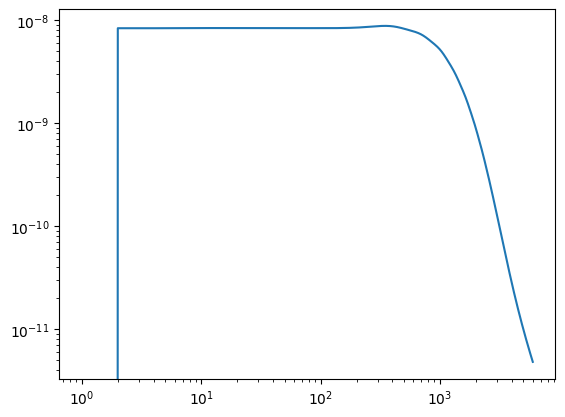

In [5]:
#https://arxiv.org/pdf/0902.4413, coding Appendix A

from lenspyx.wigners import wigners

lmax_w = 6000

A = wigners.wignerc(tau_tau, cls_unl["ee"], 0, 0, 2, 2, lmax_w)
B = wigners.wignerc(tau_tau, cls_unl["ee"], 0, 0, 2, -2, lmax_w)
cl_bb_screening_th = (A+B)/2

#plt.plot(cl_bb_tau)
plt.loglog(cl_bb_screening_th) #not sure what is happening after 200, but it should be fine for illustration

In [6]:
#from lenspyx.wigners
def wignerc(cl1: np.ndarray, cl2:np.ndarray, s1: int, t1: int, s2: int, t2: int,
            lmax_out: int = -1):

    lmax1 = len(cl1) - 1
    lmax2 = len(cl2) - 1
    lmax_out = lmax1 + lmax2 if lmax_out < 0 else lmax_out
    lmax_tot = lmax1 + lmax2 + lmax_out
    so = s1 + s2
    to = t1 + t2
    if np.any(cl1) and np.any(cl2):
        npts = (lmax_tot + 2 - lmax_tot % 2) // 2
        if not 'tht wg %s' % npts in wigners.GL_cache.keys():
            wigners.GL_cache['tht wg %s' % npts] = wigners.get_thgwg(npts)
        tht, wg = wigners.GL_cache['tht wg %s' % npts]
        if np.iscomplexobj(cl1):
            xi1 = wigners.wignerpos(np.real(cl1), tht, s1, t1) + 1j * wigners.wignerpos(np.imag(cl1), tht, s1, t1)
            print("Ciao")
        else:
            xi1 = wigners.wignerpos(cl1, tht, s1, t1)
            print("Take exponential!!", t2)
            xi1 = np.exp(4*(-1 if t2 < 0 else 1)*xi1)
        if np.iscomplexobj(cl2):
            xi2 = wigners.wignerpos(np.real(cl2), tht, s2, t2) + 1j * wigners.wignerpos(np.imag(cl2), tht, s2, t2)
        else:
            xi2 = wigners.wignerpos(cl2, tht, s2, t2)
        xi1xi2w = xi1 * xi2 * wg
        if np.iscomplexobj(xi1xi2w):
            ret =wigners.wignercoeff(np.real(xi1xi2w), tht, so, to, lmax_out)
            ret = ret + 1j * wigners.wignercoeff(np.imag(xi1xi2w), tht, so, to, lmax_out)
            return ret
        else:
            return wigners.wignercoeff(xi1xi2w, tht, so, to, lmax_out)
    else:
        return np.zeros(lmax_out + 1, dtype=float)


In [7]:
#https://arxiv.org/pdf/2111.14199 coding page 3

lmax_w = 6000
cls_alpha
thetas, wg = wigners.get_thgwg(lmax_w)
xi_alpha = wigners.wignerpos(cls_alpha, thetas, 0, 0)

np.exp(-4*xi_alpha[0])

0.9999967568781064

In [8]:
A = wignerc(cls_alpha, cls_unl["ee"], 0, 0, 2, 2, lmax_w)
B = wignerc(cls_alpha, cls_unl["ee"], 0, 0, 2, -2, lmax_w)
cl_rotation_th = (A-B)/2

Take exponential!! 2
Take exponential!! -2


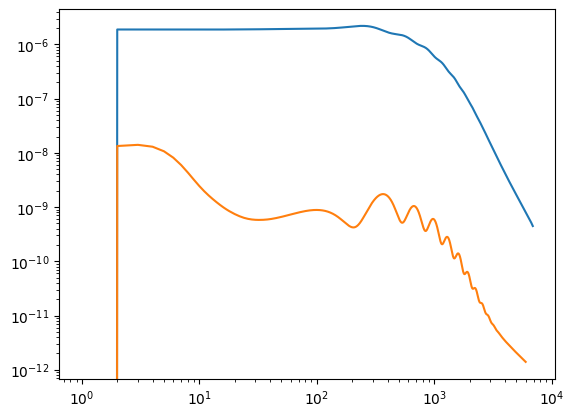

In [10]:
plt.loglog(cls_len["bb"])
plt.plot(cl_rotation_th)
#plt.plot(cl_bb_alpha)

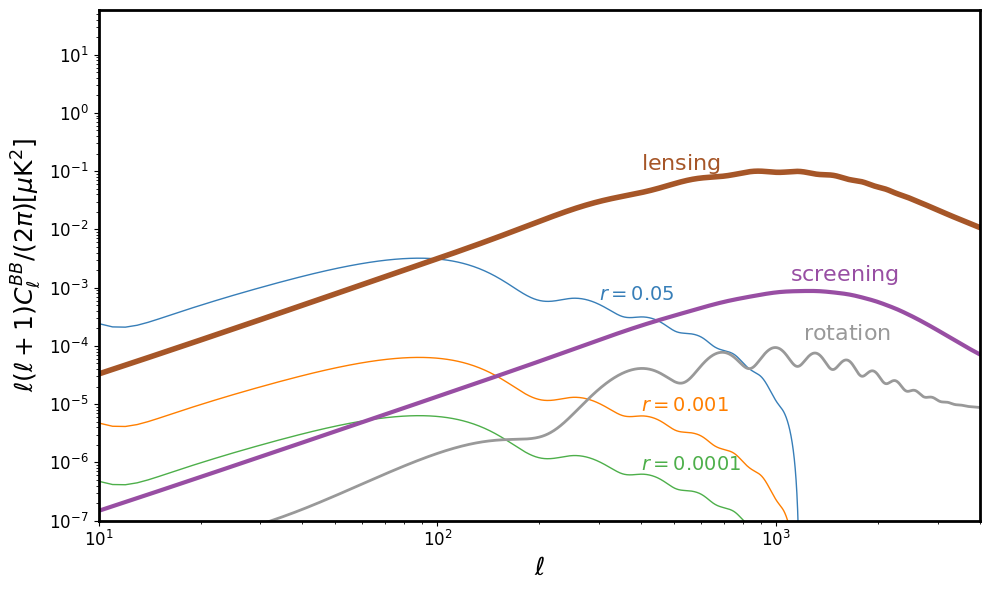

In [11]:
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

# Your CAMB setup
pars = camb.CAMBparams()
pars.set_cosmology(H0=67, ombh2=0.022445, omch2=0.1212, mnu=0)
lmax = 6000
pars.set_for_lmax(lmax+200, lens_potential_accuracy=2)
pars.max_l_tensor = 6000
pars.WantTensors = True
data = camb.get_results(pars)

# Set up the plot with bold border
plt.figure(figsize=(10, 6))
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(2)

# Generate curves for different r values
rs = [0.05, 1e-3, 1e-4]
for i, r in enumerate(rs):
    inflation_params = initialpower.InitialPowerLaw()
    inflation_params.set_params(As=2.1265e-09, ns=0.96, r=r)
    data.power_spectra_from_transfer(inflation_params)
    cl = data.get_tensor_cls(lmax, CMB_unit='muK')
    line, = plt.loglog(np.arange(lmax+1), cl[:,2], color=CB_color_cycle[i], lw = 1)
    
    # Add text label on the curve with LaTeX formatting
    idx = 400 if r < 0.05 else 300
    x_pos = idx
    y_pos = cl[idx,2] * 1.2
    plt.text(x_pos, y_pos, f'$r={r}$', color=CB_color_cycle[i], fontsize=14)

ell = np.arange(len(cls_len["bb"]))
w = ell * (ell + 1) / (2. * np.pi) 
cl = cls_len["bb"]*w
idx = 400
x_pos = idx
y_pos = cl[idx] * 2.4
plt.text(x_pos, y_pos, f'$\mathrm{{lensing}}$', color=CB_color_cycle[4], fontsize=16)
plt.plot(cl, color = CB_color_cycle[4], lw = 4)

ell = np.arange(len(cl_bb_screening_th))
w = ell * (ell + 1) / (2. * np.pi) 
cl = cl_bb_screening_th*w
idx = 1100
x_pos = idx
y_pos = cl[idx] * 1.5
plt.text(x_pos, y_pos, f'$\mathrm{{screening}}$', color=CB_color_cycle[5], fontsize=16)
plt.plot(cl, color =CB_color_cycle[5], lw = 3)

ell = np.arange(len(cl_rotation_th))
w = ell * (ell + 1) / (2. * np.pi) 
cl = cl_rotation_th*w
idx = 1200
x_pos = idx
y_pos = cl[idx] * 2.5
plt.text(x_pos, y_pos, f'$\mathrm{{rotation}}$', color=CB_color_cycle[6], fontsize=16)
plt.plot(cl, color =CB_color_cycle[6], lw = 2)

plt.xlim([2,lmax])
plt.ylabel(r'$\ell(\ell+1)C_\ell^{BB}/ (2\pi)[\mu{\rm K}^2]$', fontsize=18)
plt.xlabel(r'$\ell$', fontsize=18)
plt.ylim(1e-7)
#plt.grid(True, which='both', linestyle='--', alpha=0.5)

# Make tick labels larger
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xlim(10, 4000)

plt.tight_layout()
plt.savefig('bb_cls.pdf', dpi = 300)

In [12]:
from plancklens import shts, utils
import healpy as hp
import numpy as np

gauss_beam = hp.gauss_beam(fwhm=np.deg2rad(30./60), lmax = 6000)
conv = lambda x: hp.almxfl(x, gauss_beam)


directory = "/home/users/d/darwish/scratch/JOINTRECONSTRUCTION/ponly/simswalpha/"
blm = lambda i: hp.read_alm(directory+f"sim_{i:04}_blm.fits")
elm = lambda i: hp.read_alm(directory+f"sim_{i:04}_elm.fits")
N = 1

nside = 1024
bmode_real = shts.alm2map(conv(blm(0)), nside)
q, u = shts.alm2map_spin(np.array([conv(elm(0))*0, conv(blm(0))]), nside, 2, hp.Alm.getlmax(len(elm(0))))

"""directory = "/home/users/d/darwish/scratch/JOINTRECONSTRUCTION/aonly/simswalpha/"
blm = lambda i: hp.alm2cl(hp.read_alm(directory+f"sim_{i:04}_blm.fits"))
N = 1
cl_bb_alpha = np.mean([blm(i) for i in range(N)], axis=0)"""

Using lenspyx alm2map


'directory = "/home/users/d/darwish/scratch/JOINTRECONSTRUCTION/aonly/simswalpha/"\nblm = lambda i: hp.alm2cl(hp.read_alm(directory+f"sim_{i:04}_blm.fits"))\nN = 1\ncl_bb_alpha = np.mean([blm(i) for i in range(N)], axis=0)'

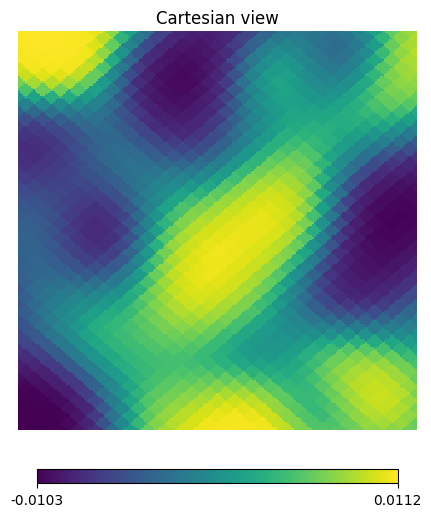

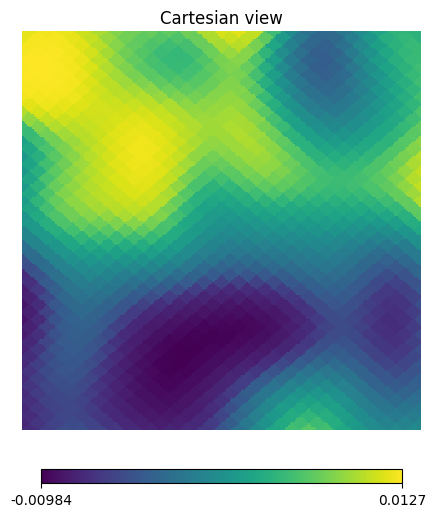

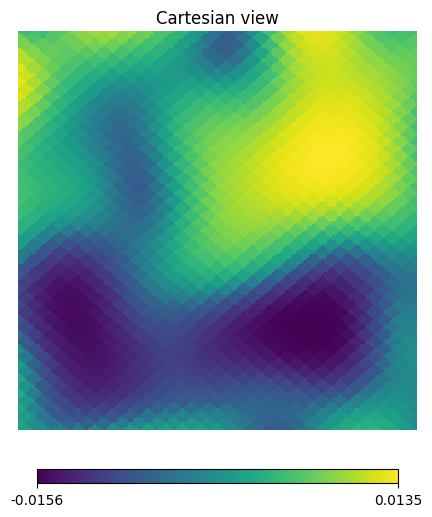

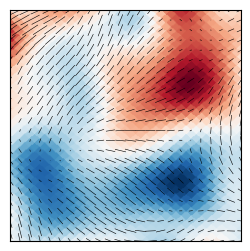

In [143]:
from matplotlib import cm


def plot_quiver(Q, U, X_width, Y_width, background=None):
    '''Visualize Stokes Q, U as headless vectors'''
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    
    # Smooth maps for nicer images
    fwhm_pix = 10

    Q = Q[::int(fwhm_pix),::int(fwhm_pix)]
    U = U[::int(fwhm_pix),::int(fwhm_pix)]
    
    p_amp = np.sqrt(Q**2 + U**2)
    ang = np.arctan2(U, Q) / 2.
    
    u = p_amp * np.cos(ang)
    v = p_amp * np.sin(ang)

    x = np.linspace(0,X_width,u.shape[1])
    y = np.linspace(0,X_width,u.shape[0])    
        
    fig, ax = plt.subplots(figsize=(3, 3))
    if background is not None:
        im = ax.imshow(background, interpolation='bilinear', origin='lower',cmap=cm.RdBu_r,
                       extent=([0,X_width,0,Y_width]))
        divider = make_axes_locatable(ax)
        #cax = divider.append_axes("right", size="5%", pad=0.05)
        #cbar = plt.colorbar(im, cax=cax)
        #cbar.set_label('temperature [uK]', rotation=270)
        
    ax.quiver(x, y, u, v, headwidth=1, headlength=0, pivot='mid', units='xy',
              scale_units='xy', scale=2 * p_amp.max(), linewidth=1)
        
    #ax.set_ylabel('angle $[^\circ]$')
    #ax.set_xlabel('angle $[^\circ]$')
    ax.set_xticks([])
    ax.set_yticks([])
    
    plt.show(fig)


dLon = 2
dLat = 2
lonRange = [-dLon/2., dLon/2.] # [deg]
latRange = [-dLat/2., dLat/2.] # [deg]
pixRes = 0.5/60.  #0.5 / 60.  # [arcmin] to [deg]


xSize = int(np.ceil(dLon / pixRes))
ySize = int(np.ceil(dLat / pixRes))

#M = 50
xsize, ysize = xSize, ySize
reso = 4


N = 1
nside = 1024
bmode_real = shts.alm2map(conv(blm(0)), nside)
q, u = shts.alm2map_spin(np.array([conv(elm(0))*0, conv(blm(0))]), nside, 2, hp.Alm.getlmax(len(elm(0))))

#q_map = hp.gnomview(q, xsize=xsize, ysize=ysize, no_plot = True, return_projected_map = True, reso = reso)
#u_map = hp.gnomview(u, xsize=xsize, ysize=ysize, no_plot = True, return_projected_map = True, reso = reso)
#b_map = hp.gnomview(bmode_real, xsize=xsize, ysize=ysize, no_plot = True, return_projected_map = True, reso = reso)

pos = (0, 0, 0)
q_map = hp.visufunc.cartview(q, lonra=lonRange, latra=latRange, xsize=xSize, ysize=ySize, return_projected_map=True, norm='hist')
u_map = hp.visufunc.cartview(u, rot=pos, lonra=lonRange, latra=latRange, xsize=xSize, ysize=ySize, return_projected_map=True, norm='hist')
b_map = hp.visufunc.cartview(bmode_real, rot=pos, lonra=lonRange, latra=latRange, xsize=xSize, ysize=ySize, return_projected_map=True, norm='hist')


L=5
plot_quiver(q_map,u_map,L,L,background=b_map)

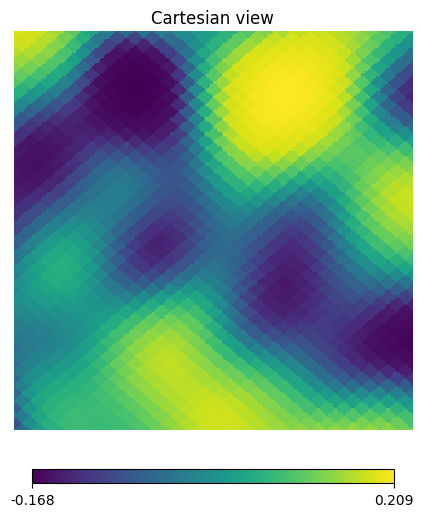

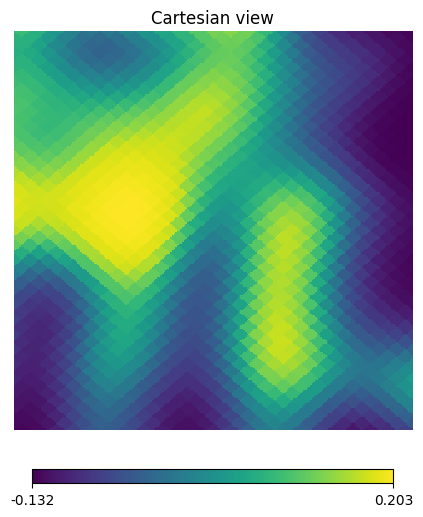

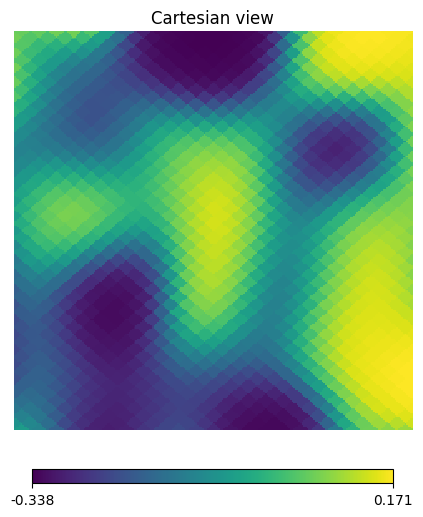

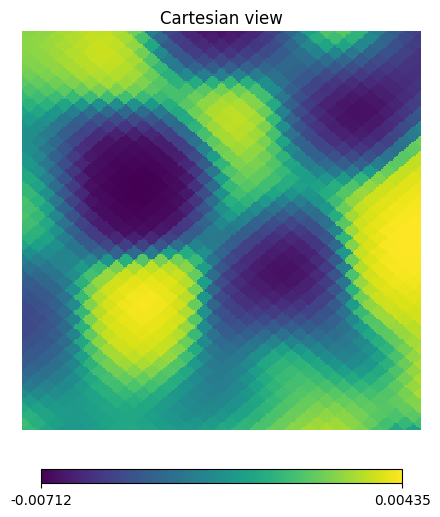

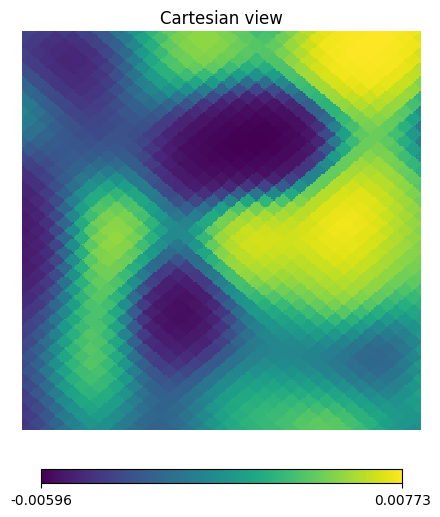

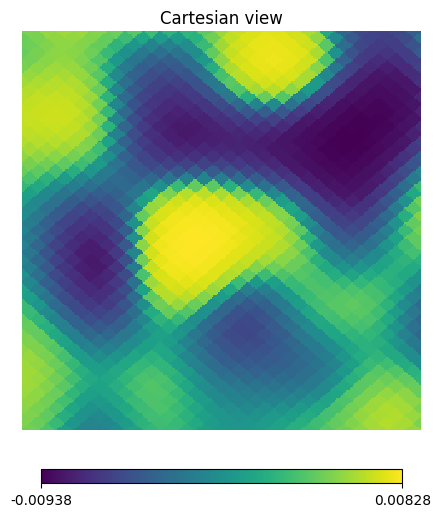

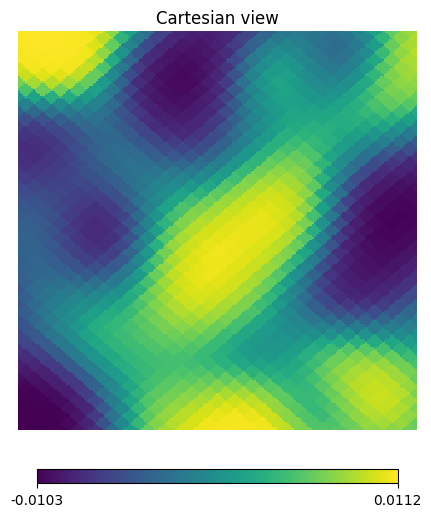

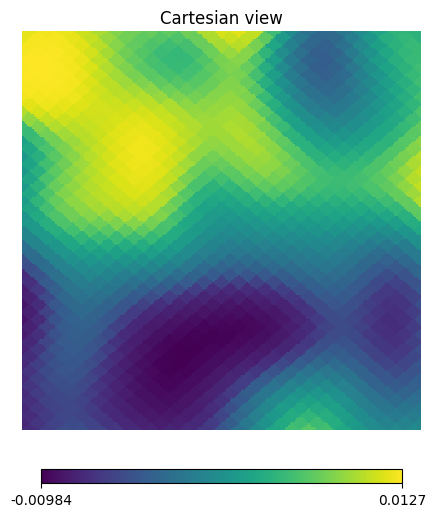

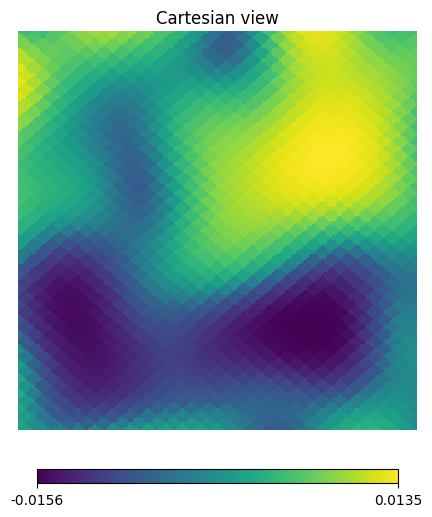

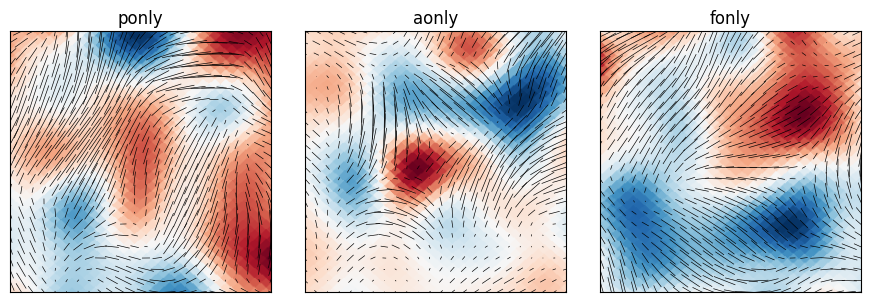

In [144]:
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_quiver_grid(Q_list, U_list, X_width, Y_width, backgrounds=None, n_cols=3, names =[]):
    '''Visualize multiple sets of Stokes Q, U as headless vectors in a horizontal grid
    
    Parameters:
    -----------
    Q_list : list of 2D arrays
        List of Q maps to plot
    U_list : list of 2D arrays
        List of U maps to plot
    X_width, Y_width : float
        Width of each plot
    backgrounds : list of 2D arrays, optional
        List of background maps to display
    n_cols : int
        Number of columns in the grid
    '''
    n_plots = len(Q_list)
    n_rows = 1 #int(np.ceil(n_plots / n_cols))
    
    # Create figure with proper size
    fig, axes = plt.subplots(n_rows, n_cols, 
                            figsize=(3*n_cols, 3*n_rows),
                            squeeze=False)
    
    # Flatten axes for easier iteration
    axes_flat = axes.flatten()
    
    # Smooth maps for nicer images
    fwhm_pix = 10
    
    for idx in range(n_plots):
        ax = axes_flat[idx]
        
        # Get current Q and U maps
        Q = Q_list[idx][::int(fwhm_pix),::int(fwhm_pix)]
        U = U_list[idx][::int(fwhm_pix),::int(fwhm_pix)]
        
        p_amp = np.sqrt(Q**2 + U**2)
        ang = np.arctan2(U, Q) / 2.
        
        u = p_amp * np.cos(ang)
        v = p_amp * np.sin(ang)

        x = np.linspace(0, X_width, u.shape[1])
        y = np.linspace(0, X_width, u.shape[0])
        
        # Plot background if provided
        if backgrounds is not None and idx < len(backgrounds):
            im = ax.imshow(backgrounds[idx], 
                          interpolation='bilinear',
                          origin='lower',
                          cmap=cm.RdBu_r,
                          extent=([0,X_width,0,Y_width]))
        
        # Plot quiver
        ax.quiver(x, y, u, v,
                 headwidth=1,
                 headlength=0,
                 pivot='mid',
                 units='xy',
                 scale_units='xy',
                 scale=2 * p_amp.max(),
                 linewidth=1)
        
        ax.set_xticks([])
        ax.set_yticks([])
        
        # Optional: Add title or other annotations
        ax.set_title(f'{names[idx]}')
    
    # Remove empty subplots
    for idx in range(n_plots, len(axes_flat)):
        fig.delaxes(axes_flat[idx])
    
    plt.tight_layout()
    return fig

# Example usage:
M = 50
xsize, ysize = M, M
reso = 4
L = 3

# Create example data (you'll need to replace this with your actual data)
# Here we're creating some sample Q and U maps with different patterns
Q_list = []
U_list = []
B_list = []

# Create sample data with different patterns
casi = ["ponly", "aonly", "fonly"]
for caso in casi:
    directory = f"/home/users/d/darwish/scratch/JOINTRECONSTRUCTION/{caso}/simswalpha/"
    blm = lambda i: hp.read_alm(directory+f"sim_{i:04}_blm.fits")
    elm = lambda i: hp.read_alm(directory+f"sim_{i:04}_elm.fits")
    nside = 1024
    bmode_real = shts.alm2map(conv(blm(0)), nside)
    q, u = shts.alm2map_spin(np.array([conv(elm(0))*0, conv(blm(0))]), nside, 2, hp.Alm.getlmax(len(elm(0))))

    q_map = hp.gnomview(q, xsize=xsize, ysize=ysize, no_plot = True, return_projected_map = True, reso = reso)
    u_map = hp.gnomview(u, xsize=xsize, ysize=ysize, no_plot = True, return_projected_map = True, reso = reso)
    b_map = hp.gnomview(bmode_real, xsize=xsize, ysize=ysize, no_plot = True, return_projected_map = True, reso = reso)

    pos = (0, 0, 0)
    q_map = hp.visufunc.cartview(q, lonra=lonRange, latra=latRange, xsize=xSize, ysize=ySize, return_projected_map=True, norm='hist')
    u_map = hp.visufunc.cartview(u, rot=pos, lonra=lonRange, latra=latRange, xsize=xSize, ysize=ySize, return_projected_map=True, norm='hist')
    b_map = hp.visufunc.cartview(bmode_real, rot=pos, lonra=lonRange, latra=latRange, xsize=xSize, ysize=ySize, return_projected_map=True, norm='hist')
            
    Q_list.append(q_map)
    U_list.append(u_map)
    B_list.append(b_map)

# Plot the grid
fig = plot_quiver_grid(Q_list, U_list, L, L, backgrounds=B_list, n_cols=3, names = casi)
plt.show()

In [65]:
def make_CMB_maps(N,pix_size,ell,DlTT,DlEE,DlTE,DlBB):
    "makes a realization of a simulated CMB sky map"

    # convert Dl to Cl, we use np.divide to avoid dividing by zero.
    dell = ell * (ell + 1) / 2 / np.pi
    ClTT = DlTT#np.divide(DlTT, dell, where=ell>1)
    ClEE = DlEE#np.divide(DlEE, dell, where=ell>1)
    ClTE = DlTE#np.divide(DlTE, dell, where=ell>1)
    ClBB = DlBB#np.divide(DlBB, dell, where=ell>1)
    
    # set the \ell = 0 and \ell =1 modes to zero as these are unmeasurmable and blow up with the above transform
    ClTT[0:2] = 0.
    ClEE[0:2] = 0.
    ClTE[0:2] = 0.
    ClBB[0:2] = 0.

    # separate the correlated and uncorrelated part of the EE spectrum
    correlated_part_of_E = np.divide(ClTE, np.sqrt(ClTT), where=ell>1)
    uncorrelated_part_of_EE = ClEE - np.divide(ClTE**2., ClTT, where=ell>1)
    
    correlated_part_of_E[0:2] = 0.
    uncorrelated_part_of_EE[0:2] = 0.
    
    # make a 2d coordinate system
    ones = np.ones(N)
    inds  = (np.arange(N) - N/2.) /(N-1.)
    X = np.outer(ones,inds)
    Y = np.transpose(X)
    R = np.sqrt(X**2. + Y**2.)
    ang = np.arctan2(Y,X)   ## we now need this angle to handle the EB <--> QU rotation
    
    # now make a set of 2d CMB masks for the T, E, and B maps
    ell_scale_factor = 2. * np.pi / (pix_size/60. * np.pi/180.)
    ell2d = R * ell_scale_factor
    ClTT_expanded = np.zeros(int(ell2d.max())+1)
    ClTT_expanded[0:(ClTT.size)] = ClTT
    ClEE_uncor_expanded = np.zeros(int(ell2d.max())+1)
    ClEE_uncor_expanded[0:(uncorrelated_part_of_EE.size)] = uncorrelated_part_of_EE
    ClE_corr_expanded = np.zeros(int(ell2d.max())+1)
    ClE_corr_expanded[0:(correlated_part_of_E.size)] = correlated_part_of_E
    ClBB_expanded = np.zeros(int(ell2d.max())+1)
    ClBB_expanded[0:(ClBB.size)] = ClBB
    CLTT2d = ClTT_expanded[ell2d.astype(int)]
    ClEE_uncor_2d = ClEE_uncor_expanded[ell2d.astype(int)]
    ClE_corr2d = ClE_corr_expanded[ell2d.astype(int)]
    CLBB2d = ClBB_expanded[ell2d.astype(int)]
    
    # now make a set of gaussian random fields that will be turned into the CMB maps
    randomn_array_for_T = np.fft.fft2(np.random.normal(0,1,(N,N)))
    randomn_array_for_E = np.fft.fft2(np.random.normal(0,1,(N,N))) 
    randomn_array_for_B = np.fft.fft2(np.random.normal(0,1,(N,N))) 
    
    ## make the T, E, and B maps by multiplying the masks against the random fields
    FT_2d = np.sqrt(CLTT2d) * randomn_array_for_T
    FE_2d = np.sqrt(ClEE_uncor_2d) * randomn_array_for_E + ClE_corr2d* randomn_array_for_T
    FB_2d = np.sqrt(CLBB2d) * randomn_array_for_B
    
    ## now conver E abd B to Q and U
    FQ_2d = FE_2d* np.cos(2.*ang) - FB_2d * np.sin(2. *ang)
    FU_2d = FE_2d* np.sin(2.*ang) + FB_2d * np.cos(2. *ang)
    
    ## convert from fourier space to real space
    CMB_T = np.fft.ifft2(np.fft.fftshift(FT_2d)) /(pix_size /60.* np.pi/180.)
    CMB_T = np.real(CMB_T)
    CMB_Q = np.fft.ifft2(np.fft.fftshift(FQ_2d)) /(pix_size /60.* np.pi/180.)
    CMB_Q = np.real(CMB_Q)
    CMB_U = np.fft.ifft2(np.fft.fftshift(FU_2d)) /(pix_size /60.* np.pi/180.)
    CMB_U = np.real(CMB_U)

    ## optional code for spitting out E and B maps 
    CMB_E = np.fft.ifft2(np.fft.fftshift(FE_2d)) /(pix_size /60.* np.pi/180.)
    CMB_E = np.real(CMB_E)
    CMB_B = np.fft.ifft2(np.fft.fftshift(FB_2d)) /(pix_size /60.* np.pi/180.)
    CMB_B = np.real(CMB_B)
    
    ## return the maps
    return(CMB_T,CMB_Q,CMB_U,CMB_E,CMB_B)
  ###############################

N = 2**8
pix_size = 1  # size of a pixel in arcminutes
N_iterations = 16
## variables to set up the map plots
c_min = -400  # minimum for color bar
c_max = 400  # maximum for color bar
X_width = N * pix_size / 60.0  # horizontal map width in degrees
Y_width = N * pix_size / 60.0  # vertical map width in degrees

DlTT,DlEE,DlTE,DlBB = cls_len["tt"][:6000], cls_len["ee"][:6000], cls_len["te"][:6000], cls_len["bb"][:6000]
ell = np.arange(len(DlTT))
## make a CMB T map
CMB_T,CMB_Q,CMB_U,CMB_E,CMB_B = make_CMB_maps(N,pix_size,ell,DlTT,DlEE*1e-15,DlTE*1e-17,DlBB)

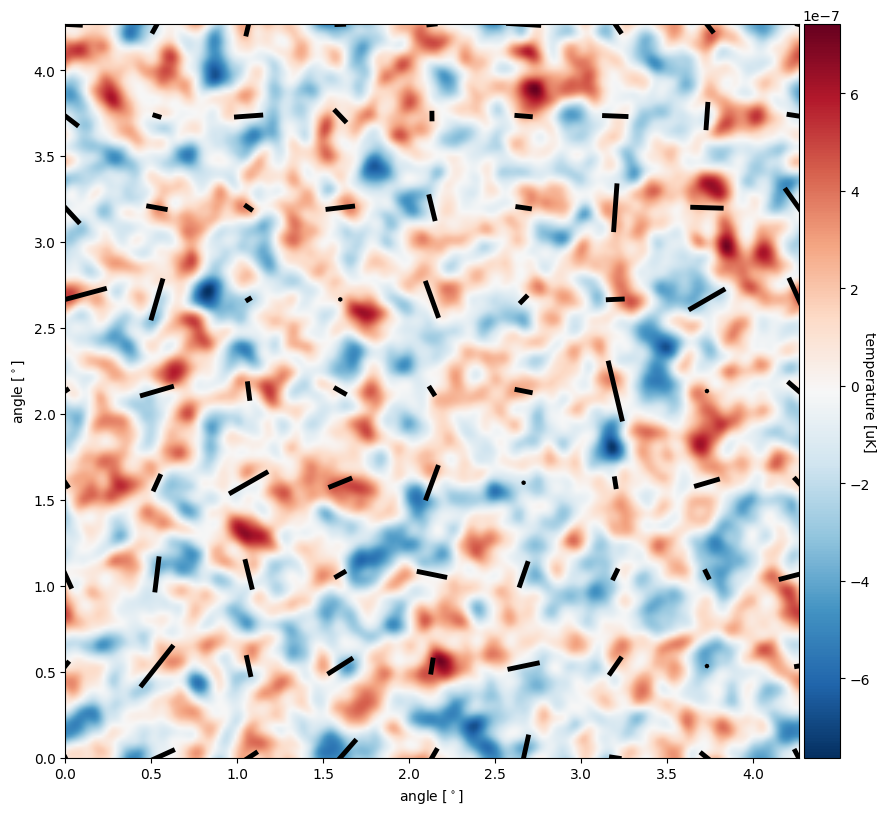

In [66]:
plot_quiver(CMB_Q,CMB_U,X_width, Y_width, background = CMB_E)

In [150]:
nside = 16  # Healpix parameter, giving 12*nside**2 equal-area pixels on the sphere.
lmax = 3*nside # band-limit. Should be 2*nside < lmax < 4*nside to get information content.
print('Number of pixels: ', hp.nside2npix(nside))

Number of pixels:  3072


In [ ]:
import scipy.special
Cells = cls_unl["bb"][:1500]
CellDiagMatrix = np.diag(np.concatenate([np.repeat(Cells[ell], 2*ell+1) for ell in range(lmax)]))
thetas, phis = hp.pix2ang(nside, np.arange(hp.nside2npix(nside)))
YellmMatrix = np.zeros((lmax**2, hp.nside2npix(nside)), dtype=complex)
for ell in range(lmax):
    for em in range(-ell, ell+1):
        YellmMatrix[ell*ell + ell + em, :] = scipy.special.sph_harm(em, ell, phis, thetas)
pixelPixelCovarianceMatrix = np.abs(np.dot(np.conjugate(YellmMatrix).T, np.dot(CellDiagMatrix, YellmMatrix)))

/tmp/ipykernel_934697/3694168761.py:8: DeprecationWarning: `scipy.special.sph_harm` is deprecated as of SciPy 1.15.0 and will be removed in SciPy 1.17.0. Please use `scipy.special.sph_harm_y` instead.
  YellmMatrix[ell*ell + ell + em, :] = scipy.special.sph_harm(em, ell, phis, thetas)


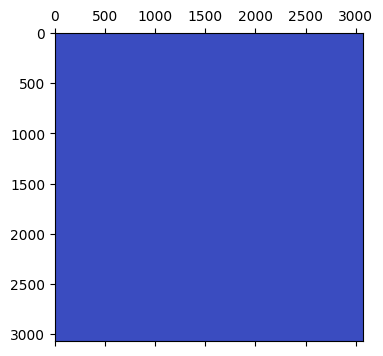

In [168]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.matshow(pixelPixelCovarianceMatrix, cmap="coolwarm")

In [160]:
caso = "fonly"
directory = f"/home/users/d/darwish/scratch/JOINTRECONSTRUCTION/{caso}/simswalpha/"
fieldlm = lambda i: hp.read_alm(directory+f"sim_{i:04}_tau_lm.fits")
field = shts.alm2map(fieldlm(0), nside)
operator = np.exp(-field)
operator = np.diag(operator)

In [169]:
final = operator@pixelPixelCovarianceMatrix@operator.T

/tmp/ipykernel_934697/1912916433.py:2: RuntimeWarning: divide by zero encountered in log10
  ax.matshow(np.log10(abs(final-pixelPixelCovarianceMatrix)), cmap="coolwarm")


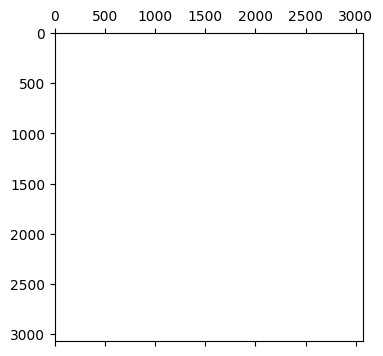

In [170]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.matshow(np.log10(abs(final-pixelPixelCovarianceMatrix)), cmap="coolwarm")

In [50]:
def make_CMB_maps(N,pix_size,ell,DlTT, return_2D_spec = False):
    "makes a realization of a simulated CMB sky map"

    # convert Dl to Cl, we use np.divide to avoid dividing by zero.
    dell = ell * (ell + 1) / 2 / np.pi
    ClTT = DlTT#np.divide(DlTT, dell, where=ell>1)
    
    # set the \ell = 0 and \ell =1 modes to zero as these are unmeasurmable and blow up with the above transform
    ClTT[0:2] = 0.
    
    # make a 2d coordinate system
    ones = np.ones(N)
    inds  = (np.arange(N) - N/2.) /(N-1.)
    X = np.outer(ones,inds)
    Y = np.transpose(X)
    R = np.sqrt(X**2. + Y**2.)
    ang = np.arctan2(Y,X)   ## we now need this angle to handle the EB <--> QU rotation
    
    # now make a set of 2d CMB masks for the T, E, and B maps
    ell_scale_factor = 2. * np.pi / (pix_size/60. * np.pi/180.)
    ell2d = R * ell_scale_factor
    ClTT_expanded = np.zeros(int(ell2d.max())+1)
    ClTT_expanded[0:(ClTT.size)] = ClTT
    CLTT2d = ClTT_expanded[ell2d.astype(int)]
    
    # now make a set of gaussian random fields that will be turned into the CMB maps
    randomn_array_for_T = np.fft.fft2(np.random.normal(0,1,(N,N)))
    
    ## make the T, E, and B maps by multiplying the masks against the random fields
    FT_2d = np.sqrt(CLTT2d) * randomn_array_for_T #T_L
    
    ## convert from fourier space to real space
    CMB_T = np.fft.ifft2(np.fft.fftshift(FT_2d)) /(pix_size /60.* np.pi/180.)
    CMB_T = np.real(CMB_T)    
    ## return the maps
    if return_2D_spec:
        return CMB_T, FT_2d, CLTT2d
    else:
        return CMB_T, FT_2d
  ###############################


def get_ells(N, pix_size):
    # This function returns Fourier wavenumbers for a Cartesian square grid
    N = int(N)
    ones = np.ones(N)
    inds = (np.arange(N) + 0.5 - N / 2.0) / (N - 1.0)
    ell_scale_factor = 2.0 * np.pi
    lx = np.outer(ones, inds) / (pix_size / 60.0 * np.pi / 180.0) * ell_scale_factor
    ly = np.transpose(lx)
    modlmap = np.sqrt(lx**2.0 + ly**2.0)
    return ly, lx, modlmap

In [63]:
N = 2**8
pix_size = 1  # size of a pixel in arcminutes
N_iterations = 16
## variables to set up the map plots
c_min = -400  # minimum for color bar
c_max = 400  # maximum for color bar
X_width = N * pix_size / 60.0  # horizontal map width in degrees
Y_width = N * pix_size / 60.0  # vertical map width in degrees

DlTT,DlEE,DlTE,DlBB = cls_unl["tt"][:6000], cls_unl["ee"][:6000], cls_unl["te"][:6000], cls_unl["bb"][:6000]
ell = np.arange(len(DlTT))

tau_tau_cl = tau_tau[:6000]
alpha_alpha_cl = cls_alpha[:6000]
pp_cl = cls_unl["pp"][:6000]

In [64]:
_, _, Cl2D = make_CMB_maps(N,pix_size,ell,DlEE, return_2D_spec = True)
plt.imshow(np.log10(Cl2D))

/tmp/ipykernel_1949200/1231346672.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(Cl2D))


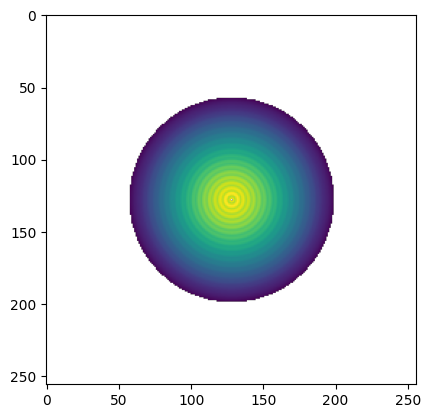

In [65]:
plt.imshow(np.log10(Cl2D))

In [18]:
phi, phi_L = make_CMB_maps(N,pix_size,ell,pp_cl)

tau, tau_L = make_CMB_maps(N,pix_size,ell,tau_tau_cl)

alpha, alpha_L = make_CMB_maps(N,pix_size,ell,alpha_alpha_cl)

In [86]:
ly, lx, modlmap = get_ells(N, pix_size)

index_x, index_y = 60, 60
Lx = lx[index_x, index_y]
Ly = 0

L_dot_l = Lx*lx+ly*Ly

alpha_l = np.arctan(ly/lx)
alpha_L_minus_l = np.arctan((Ly-ly)/(Lx-lx))

difference = 2*(alpha_l-alpha_L_minus_l)
sin = np.sin(difference)

mode = phi_L[index_x, index_y]
mode = 1.

aniso_lensing = Cl2D+mode*Cl2D*L_dot_l*sin

/tmp/ipykernel_1949200/2315783049.py:10: RuntimeWarning: divide by zero encountered in divide
  alpha_L_minus_l = np.arctan((Ly-ly)/(Lx-lx))


/tmp/ipykernel_1949200/1854962968.py:3: RuntimeWarning: divide by zero encountered in log10
  plot = np.log10(plot)


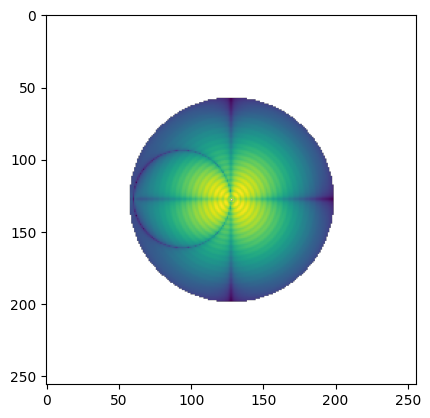

In [90]:
aniso_lensing = Cl2D*(1+sin*L_dot_l)
plot = np.abs(sin*L_dot_l*Cl2D)
plt.imshow(plot)

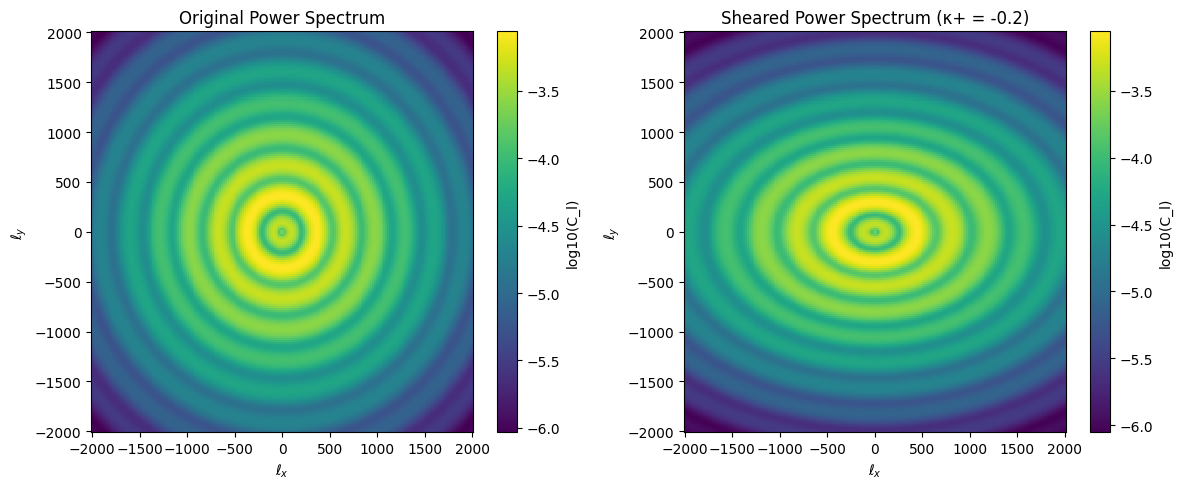

In [93]:
import numpy as np
import matplotlib.pyplot as plt

def get_lensing_power_spectrum(l):
    """
    Generate a simple model for the lensing potential power spectrum
    Based on the general shape shown in Fig. 1 of the paper
    """
    # Simple parameterization to match rough shape in paper
    ls = np.arange(len(DlEE))
    return np.interp(l, ls, DlEE)

def apply_shear(lx, ly, kappa_plus):
    """
    Apply shear transformation to Fourier coordinates
    """
    lx_new = np.exp(kappa_plus) * lx
    ly_new = np.exp(-kappa_plus) * ly
    return lx_new, ly_new

def compute_2d_power_spectrum(lmax=2000, nl=100, kappa_plus=0.1):
    """
    Compute 2D power spectrum with shear effects
    """
    # Create 2D grid of l values
    lx = np.linspace(-lmax, lmax, nl)
    ly = np.linspace(-lmax, lmax, nl)
    LX, LY = np.meshgrid(lx, ly)
    
    # Compute l magnitude
    L = np.sqrt(LX**2 + LY**2)
    
    # Base power spectrum (no shear)
    power_no_shear = get_lensing_power_spectrum(L)
    
    # Apply shear transformation
    LX_sheared, LY_sheared = apply_shear(LX, LY, kappa_plus)
    L_sheared = np.sqrt(LX_sheared**2 + LY_sheared**2)
    
    # Compute sheared power spectrum
    power_sheared = get_lensing_power_spectrum(L_sheared)
    
    return LX, LY, power_no_shear, power_sheared

def plot_power_spectra(lmax=2000, nl=100, kappa_plus=0.1):
    """
    Create comparison plot of power spectra with and without shear
    """
    LX, LY, power_no_shear, power_sheared = compute_2d_power_spectrum(
        lmax=lmax, nl=nl, kappa_plus=kappa_plus
    )
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Plot original power spectrum
    im1 = ax1.pcolormesh(LX, LY, np.log10(power_no_shear), 
                         shading='auto', cmap='viridis')
    ax1.set_title('Original Power Spectrum')
    ax1.set_xlabel('$\\ell_x$')
    ax1.set_ylabel('$\\ell_y$')
    plt.colorbar(im1, ax=ax1, label='log10(C_l)')
    
    # Plot sheared power spectrum
    im2 = ax2.pcolormesh(LX, LY, np.log10(power_sheared), 
                         shading='auto', cmap='viridis')
    ax2.set_title(f'Sheared Power Spectrum (κ+ = {kappa_plus})')
    ax2.set_xlabel('$\\ell_x$')
    ax2.set_ylabel('$\\ell_y$')
    plt.colorbar(im2, ax=ax2, label='log10(C_l)')
    
    plt.tight_layout()
    return fig, (ax1, ax2)

# Generate plots
fig, axes = plot_power_spectra(lmax=2000, nl=200, kappa_plus=-0.2)
plt.show()

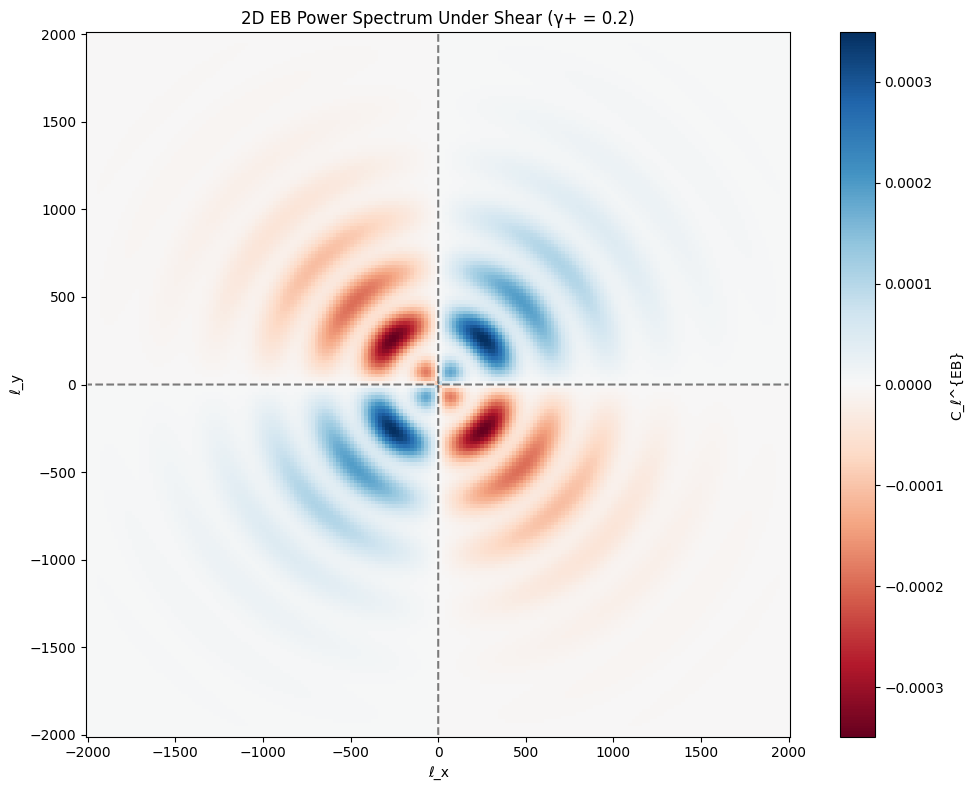

In [94]:
import numpy as np
import matplotlib.pyplot as plt

def get_EE_power(l):
    """
    Simple model for EE power spectrum
    """
    # Rough approximation of EE shape
    ls = np.arange(len(DlEE))
    return np.interp(l, ls, DlEE)

def compute_EB_power(lx, ly, gamma_plus):
    """
    Compute EB power spectrum under shear according to eq 2.11
    C̃EB_ℓ = -2CEE_ℓ [γ× cos(2φℓ) - γ+ sin(2φℓ)]
    Here we use only γ+ for simplicity
    """
    l = np.sqrt(lx**2 + ly**2)
    phi_l = np.arctan2(ly, lx)
    
    # Get base EE power
    CEE = get_EE_power(l)
    
    # Apply shear transformation
    # Using negative gamma_plus to match Figure 6 orientation in the paper
    CEB = -2 * CEE * (-gamma_plus * np.sin(2*phi_l))
    
    return CEB

# Set up grid
lmax = 2000
nl = 200
l = np.linspace(-lmax, lmax, nl)
LX, LY = np.meshgrid(l, l)

# Compute power spectra
gamma_plus = 0.2  # Shear strength
EB_power = compute_EB_power(LX, LY, gamma_plus)

# Plot
plt.figure(figsize=(10, 8))
im = plt.pcolormesh(LX, LY, EB_power, 
                    cmap='RdBu',
                    shading='auto')
plt.colorbar(im, label='C_ℓ^{EB}')

# Add multipole labels
plt.xlabel('ℓ_x')
plt.ylabel('ℓ_y')
plt.title('2D EB Power Spectrum Under Shear (γ+ = 0.2)')

# Add zero contours
plt.contour(LX, LY, EB_power, levels=[0], colors='k', linestyles='--', alpha=0.5)

# Make plot square and centered
plt.axis('square')
plt.tight_layout()
plt.show()

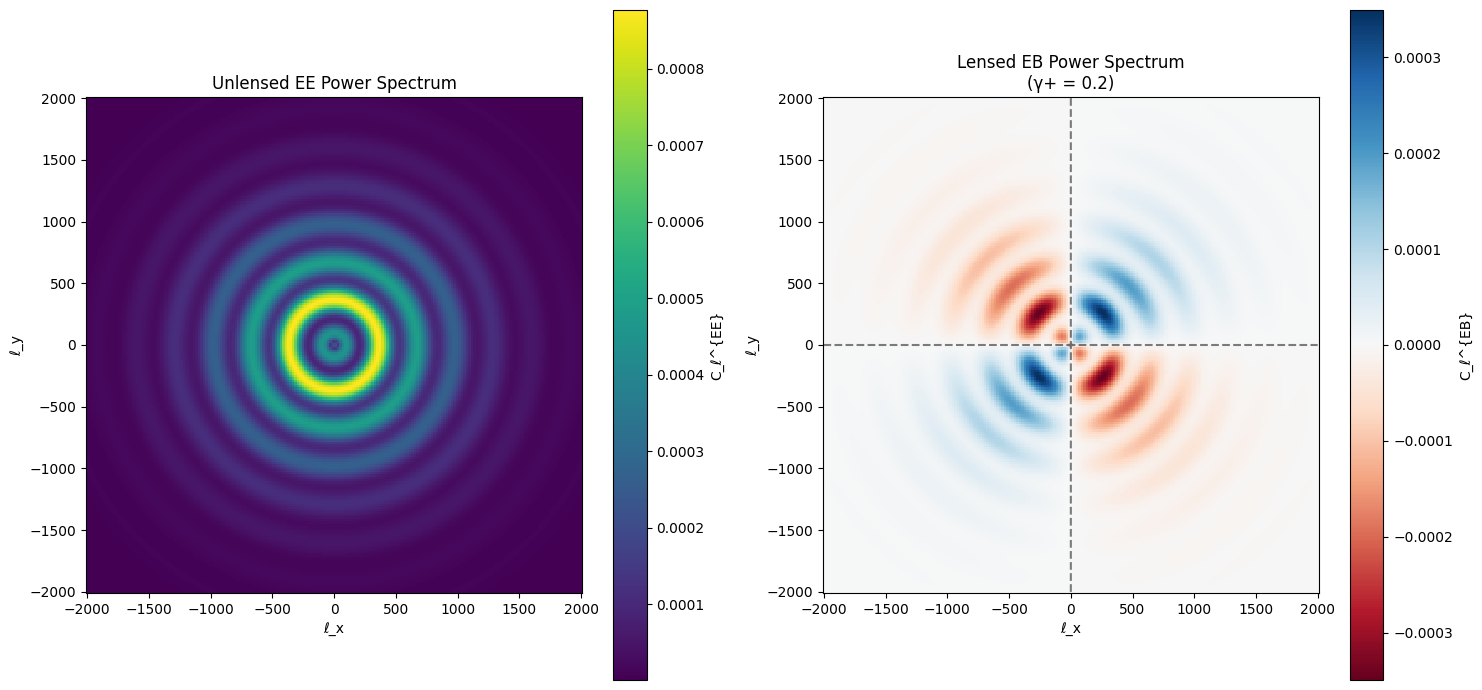

In [95]:
import numpy as np
import matplotlib.pyplot as plt

def get_EE_power(l):
    """
    Simple model for EE power spectrum
    """
    # Rough approximation of EE shape
    ls = np.arange(len(DlEE))
    return np.interp(l, ls, DlEE)

def compute_EB_power(lx, ly, gamma_plus):
    """
    Compute EB power spectrum under shear according to eq 2.11
    C̃EB_ℓ = -2CEE_ℓ [γ× cos(2φℓ) - γ+ sin(2φℓ)]
    Here we use only γ+ for simplicity
    """
    l = np.sqrt(lx**2 + ly**2)
    phi_l = np.arctan2(ly, lx)
    
    # Get base EE power
    CEE = get_EE_power(l)
    
    # Apply shear transformation
    # Using negative gamma_plus to match Figure 6 orientation in the paper
    CEB = -2 * CEE * (-gamma_plus * np.sin(2*phi_l))
    
    return CEB

# Set up grid
lmax = 2000
nl = 200
l = np.linspace(-lmax, lmax, nl)
LX, LY = np.meshgrid(l, l)
L = np.sqrt(LX**2 + LY**2)

# Compute power spectra
gamma_plus = 0.2  # Shear strength

# Unlensed EE power (isotropic)
EE_power = get_EE_power(L)

# Lensed EB power
EB_power = compute_EB_power(LX, LY, gamma_plus)

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

# Plot unlensed EE
im1 = ax1.pcolormesh(LX, LY, EE_power, 
                     cmap='viridis',
                     shading='auto')
plt.colorbar(im1, ax=ax1, label='C_ℓ^{EE}')
ax1.set_xlabel('ℓ_x')
ax1.set_ylabel('ℓ_y')
ax1.set_title('Unlensed EE Power Spectrum')

# Plot lensed EB
im2 = ax2.pcolormesh(LX, LY, EB_power, 
                     cmap='RdBu',
                     shading='auto')
plt.colorbar(im2, ax=ax2, label='C_ℓ^{EB}')
ax2.set_xlabel('ℓ_x')
ax2.set_ylabel('ℓ_y')
ax2.set_title('Lensed EB Power Spectrum\n(γ+ = 0.2)')

# Add zero contours to EB plot
ax2.contour(LX, LY, EB_power, levels=[0], colors='k', linestyles='--', alpha=0.5)

# Make plots square
ax1.set_aspect('equal')
ax2.set_aspect('equal')

plt.tight_layout()
plt.show()

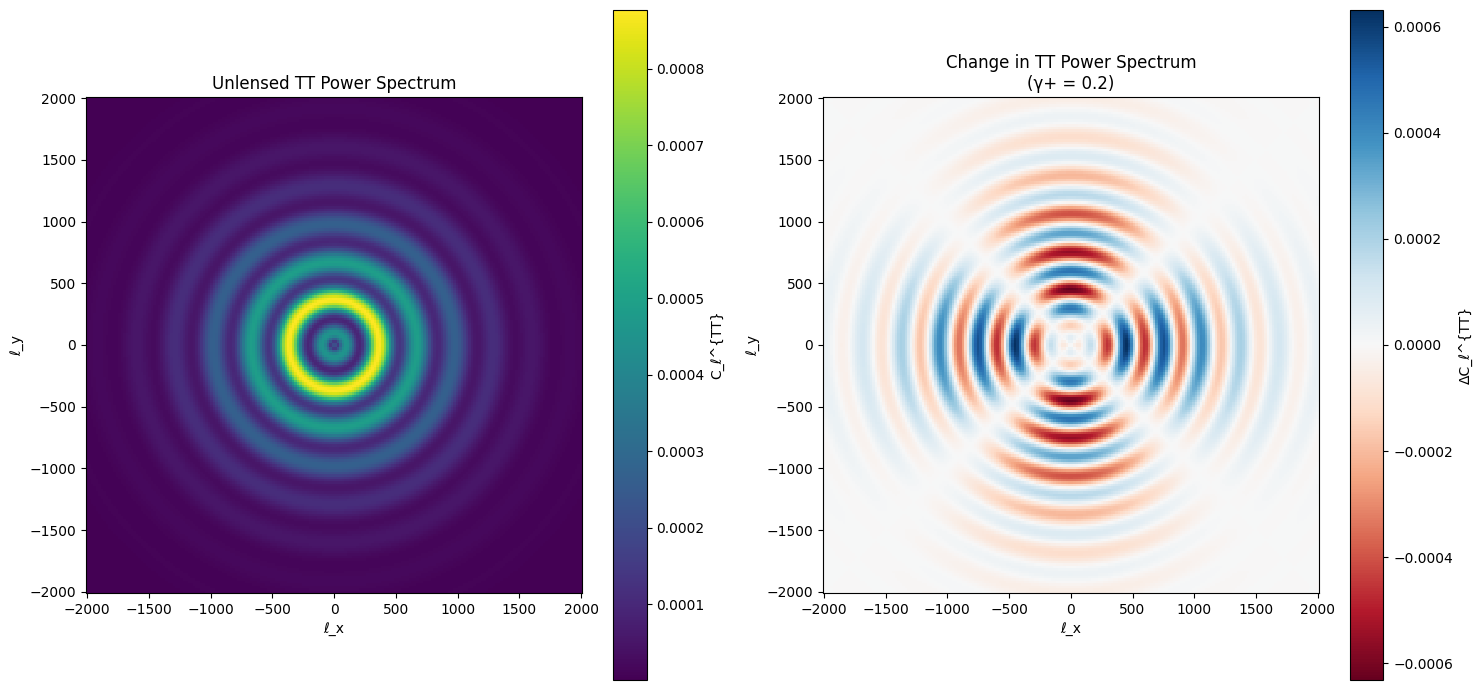

In [97]:
import numpy as np
import matplotlib.pyplot as plt

def get_TT_power(l):
    """
    Simple model for TT power spectrum with acoustic peaks
    """
    # Rough approximation of TT shape with acoustic oscillations
    ls = np.arange(len(DlEE))
    return np.interp(l, ls, DlEE)

def compute_lensed_TT(lx, ly, gamma_plus):
    """
    Compute lensed TT power spectrum under shear according to eq 2.10:
    C̃TT_ℓ = CTT_ℓ - κ0(dCTT_ℓ/dlnℓ + 2CTT_ℓ) - (γ+ cos(2φℓ) + γ× sin(2φℓ))dCTT_ℓ/dlnℓ
    Here we use only γ+ for simplicity
    """
    l = np.sqrt(lx**2 + ly**2)
    phi_l = np.arctan2(ly, lx)
    
    # Get base TT power and its logarithmic derivative
    CTT = get_TT_power(l)
    
    # Compute logarithmic derivative numerically
    dl = 0.01
    dCTT = (get_TT_power(l*(1+dl)) - get_TT_power(l*(1-dl)))/(2*dl)
    
    # Apply shear transformation
    # Using negative gamma_plus to match previous orientation
    lensed_TT = CTT - (-gamma_plus * np.cos(2*phi_l)) * dCTT
    
    return lensed_TT

# Set up grid
lmax = 2000
nl = 200
l = np.linspace(-lmax, lmax, nl)
LX, LY = np.meshgrid(l, l)
L = np.sqrt(LX**2 + LY**2)

# Compute power spectra
gamma_plus = -0.2  # Same shear strength as before

# Unlensed TT power (isotropic)
TT_power = get_TT_power(L)

# Lensed TT power
lensed_TT_power = compute_lensed_TT(LX, LY, gamma_plus)

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

# Plot unlensed TT
im1 = ax1.pcolormesh(LX, LY, TT_power, 
                     cmap='viridis',
                     shading='auto')
plt.colorbar(im1, ax=ax1, label='C_ℓ^{TT}')
ax1.set_xlabel('ℓ_x')
ax1.set_ylabel('ℓ_y')
ax1.set_title('Unlensed TT Power Spectrum')

# Plot lensed TT
delta_TT = lensed_TT_power - TT_power  # Show the difference
im2 = ax2.pcolormesh(LX, LY, delta_TT, 
                     cmap='RdBu',
                     shading='auto')
plt.colorbar(im2, ax=ax2, label='ΔC_ℓ^{TT}')
ax2.set_xlabel('ℓ_x')
ax2.set_ylabel('ℓ_y')
ax2.set_title('Change in TT Power Spectrum\n(γ+ = 0.2)')

# Make plots square
ax1.set_aspect('equal')
ax2.set_aspect('equal')

plt.tight_layout()
plt.show()

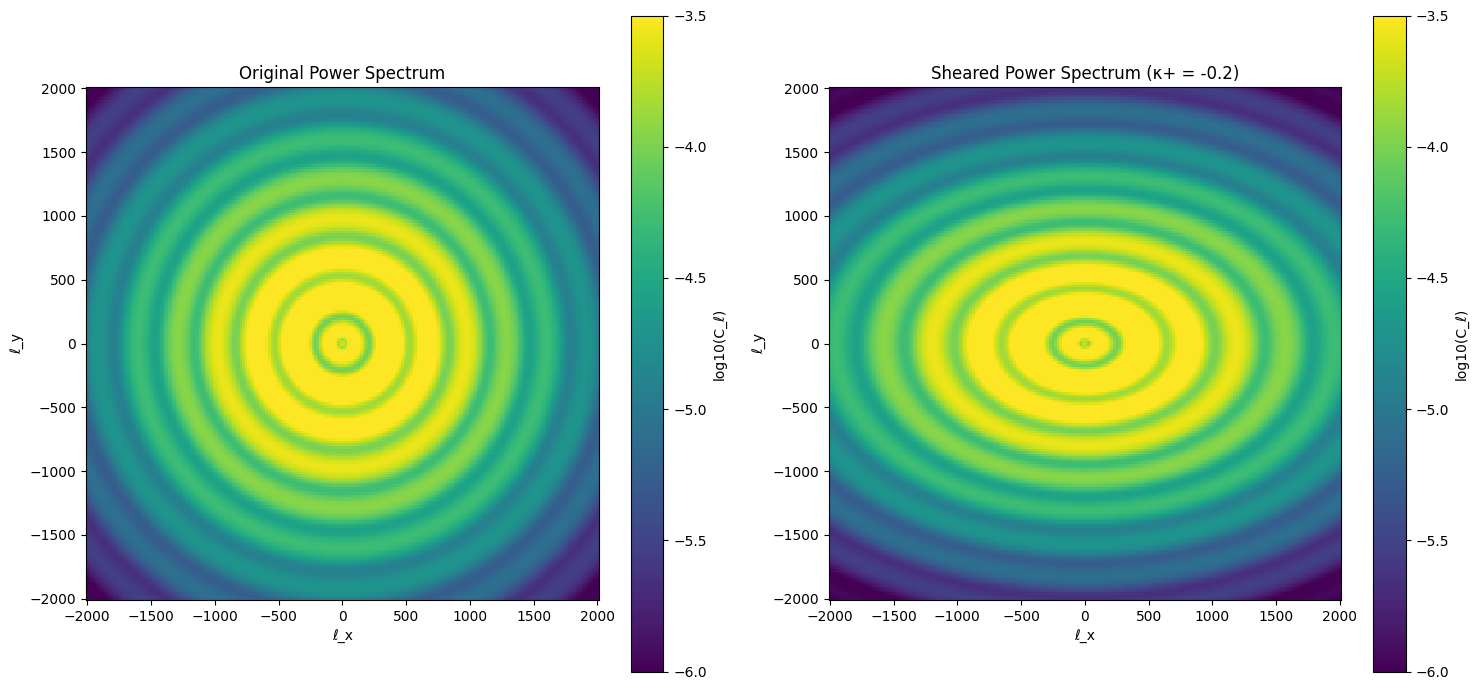

In [98]:
import numpy as np
import matplotlib.pyplot as plt

def get_power_spectrum(lx, ly):
    """
    Simple model for power spectrum with acoustic peaks
    """
    l = np.sqrt(lx**2 + ly**2)
    # Base power law with exponential cutoff
    ls = np.arange(len(DlEE))
    return np.interp(l, ls, DlEE)

def apply_shear(lx, ly, kappa_plus):
    """
    Apply shear transformation in Fourier space:
    ℓ'x = exp(+κ+)ℓx
    ℓ'y = exp(-κ+)ℓy
    """
    lx_new = np.exp(kappa_plus) * lx
    ly_new = np.exp(-kappa_plus) * ly
    return lx_new, ly_new

# Set up grid
lmax = 2000
nl = 200
l = np.linspace(-lmax, lmax, nl)
LX, LY = np.meshgrid(l, l)

# Compute original power spectrum
original_power = get_power_spectrum(LX, LY)

# Apply shear transformation
kappa_plus = -0.2  # Negative to match your plot
LX_sheared, LY_sheared = apply_shear(LX, LY, kappa_plus)
sheared_power = get_power_spectrum(LX_sheared, LY_sheared)

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

# Plot original power spectrum
im1 = ax1.pcolormesh(LX, LY, np.log10(original_power), 
                     cmap='viridis',
                     shading='auto',
                     vmin=-6.0, vmax=-3.5)
plt.colorbar(im1, ax=ax1, label='log10(C_ℓ)')
ax1.set_xlabel('ℓ_x')
ax1.set_ylabel('ℓ_y')
ax1.set_title('Original Power Spectrum')

# Plot sheared power spectrum
im2 = ax2.pcolormesh(LX, LY, np.log10(sheared_power), 
                     cmap='viridis',
                     shading='auto',
                     vmin=-6.0, vmax=-3.5)
plt.colorbar(im2, ax=ax2, label='log10(C_ℓ)')
ax2.set_xlabel('ℓ_x')
ax2.set_ylabel('ℓ_y')
ax2.set_title(f'Sheared Power Spectrum (κ+ = {kappa_plus})')

# Make plots square
ax1.set_aspect('equal')
ax2.set_aspect('equal')

plt.tight_layout()
plt.show()

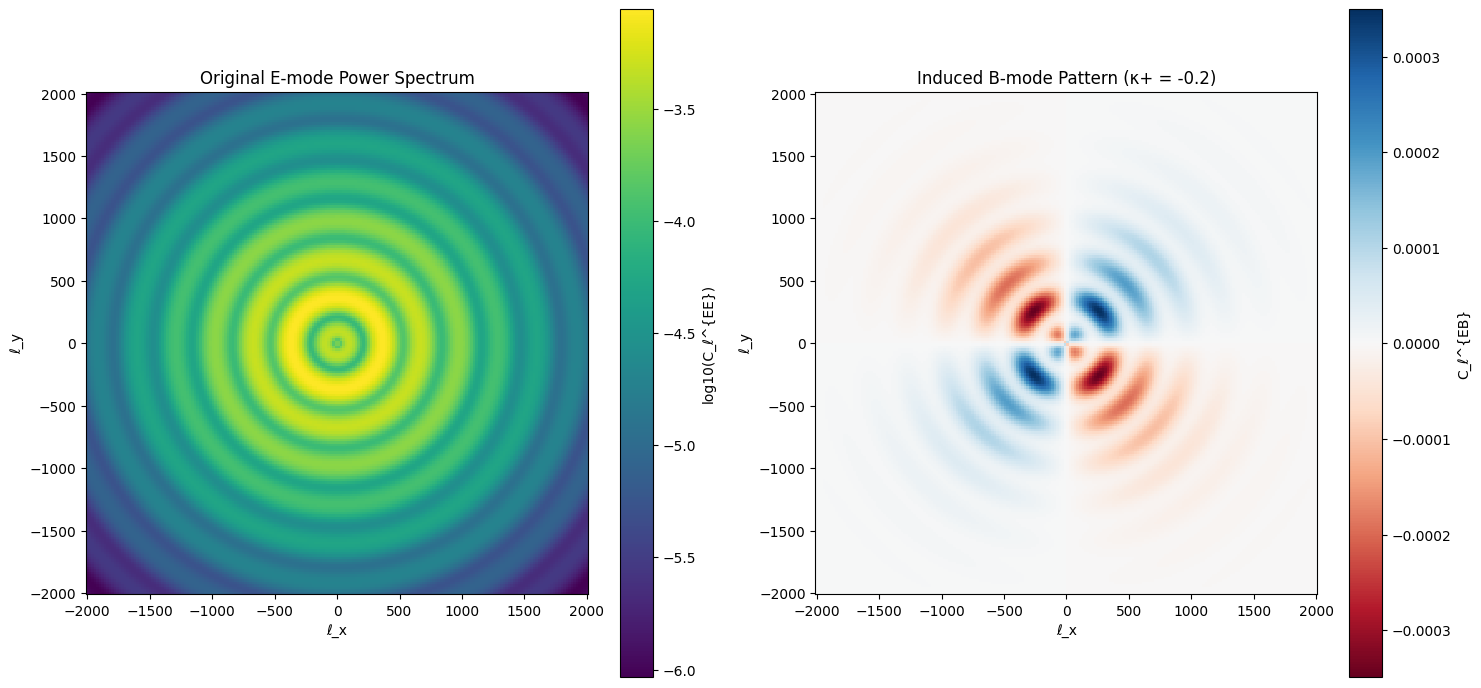

In [100]:
import numpy as np
import matplotlib.pyplot as plt

def get_E_power(lx, ly):
    """
    Simple model for power spectrum with acoustic peaks
    """
    l = np.sqrt(lx**2 + ly**2)
    # Base power law with exponential cutoff
    ls = np.arange(len(DlEE))
    return np.interp(l, ls, DlEE)

def apply_shear_transformation(lx, ly, kappa_plus):
    """
    Apply shear transformation in Fourier space
    """
    lx_new = np.exp(kappa_plus) * lx
    ly_new = np.exp(-kappa_plus) * ly
    return lx_new, ly_new

def compute_lensed_B(lx, ly, E_power, kappa_plus):
    """
    Compute lensed B-mode from pure E-mode input under shear
    """
    phi_l = np.arctan2(ly, lx)
    # Include the sin(2φ) modulation from equation 2.6
    return -2 * E_power * kappa_plus * np.sin(2*phi_l)

# Set up grid
lmax = 2000
nl = 200
l = np.linspace(-lmax, lmax, nl)
LX, LY = np.meshgrid(l, l)

# Compute original E-mode power
E_power = get_E_power(LX, LY)

# Apply shear transformation and compute B-mode
kappa_plus = -0.2
LX_sheared, LY_sheared = apply_shear_transformation(LX, LY, kappa_plus)
B_power = compute_lensed_B(LX, LY, E_power, kappa_plus)

# Create figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

# Plot original E-mode power
im1 = ax1.pcolormesh(LX, LY, np.log10(E_power), 
                     cmap='viridis',
                     shading='auto')
plt.colorbar(im1, ax=ax1, label='log10(C_ℓ^{EE})')
ax1.set_xlabel('ℓ_x')
ax1.set_ylabel('ℓ_y')
ax1.set_title('Original E-mode Power Spectrum')

# Plot induced B-mode power
im2 = ax2.pcolormesh(LX, LY, B_power,
                     cmap='RdBu',
                     shading='auto')
plt.colorbar(im2, ax=ax2, label='C_ℓ^{EB}')
ax2.set_xlabel('ℓ_x')
ax2.set_ylabel('ℓ_y')
ax2.set_title(f'Induced B-mode Pattern (κ+ = {kappa_plus})')

# Make plots square
ax1.set_aspect('equal')
ax2.set_aspect('equal')

plt.tight_layout()
plt.show()

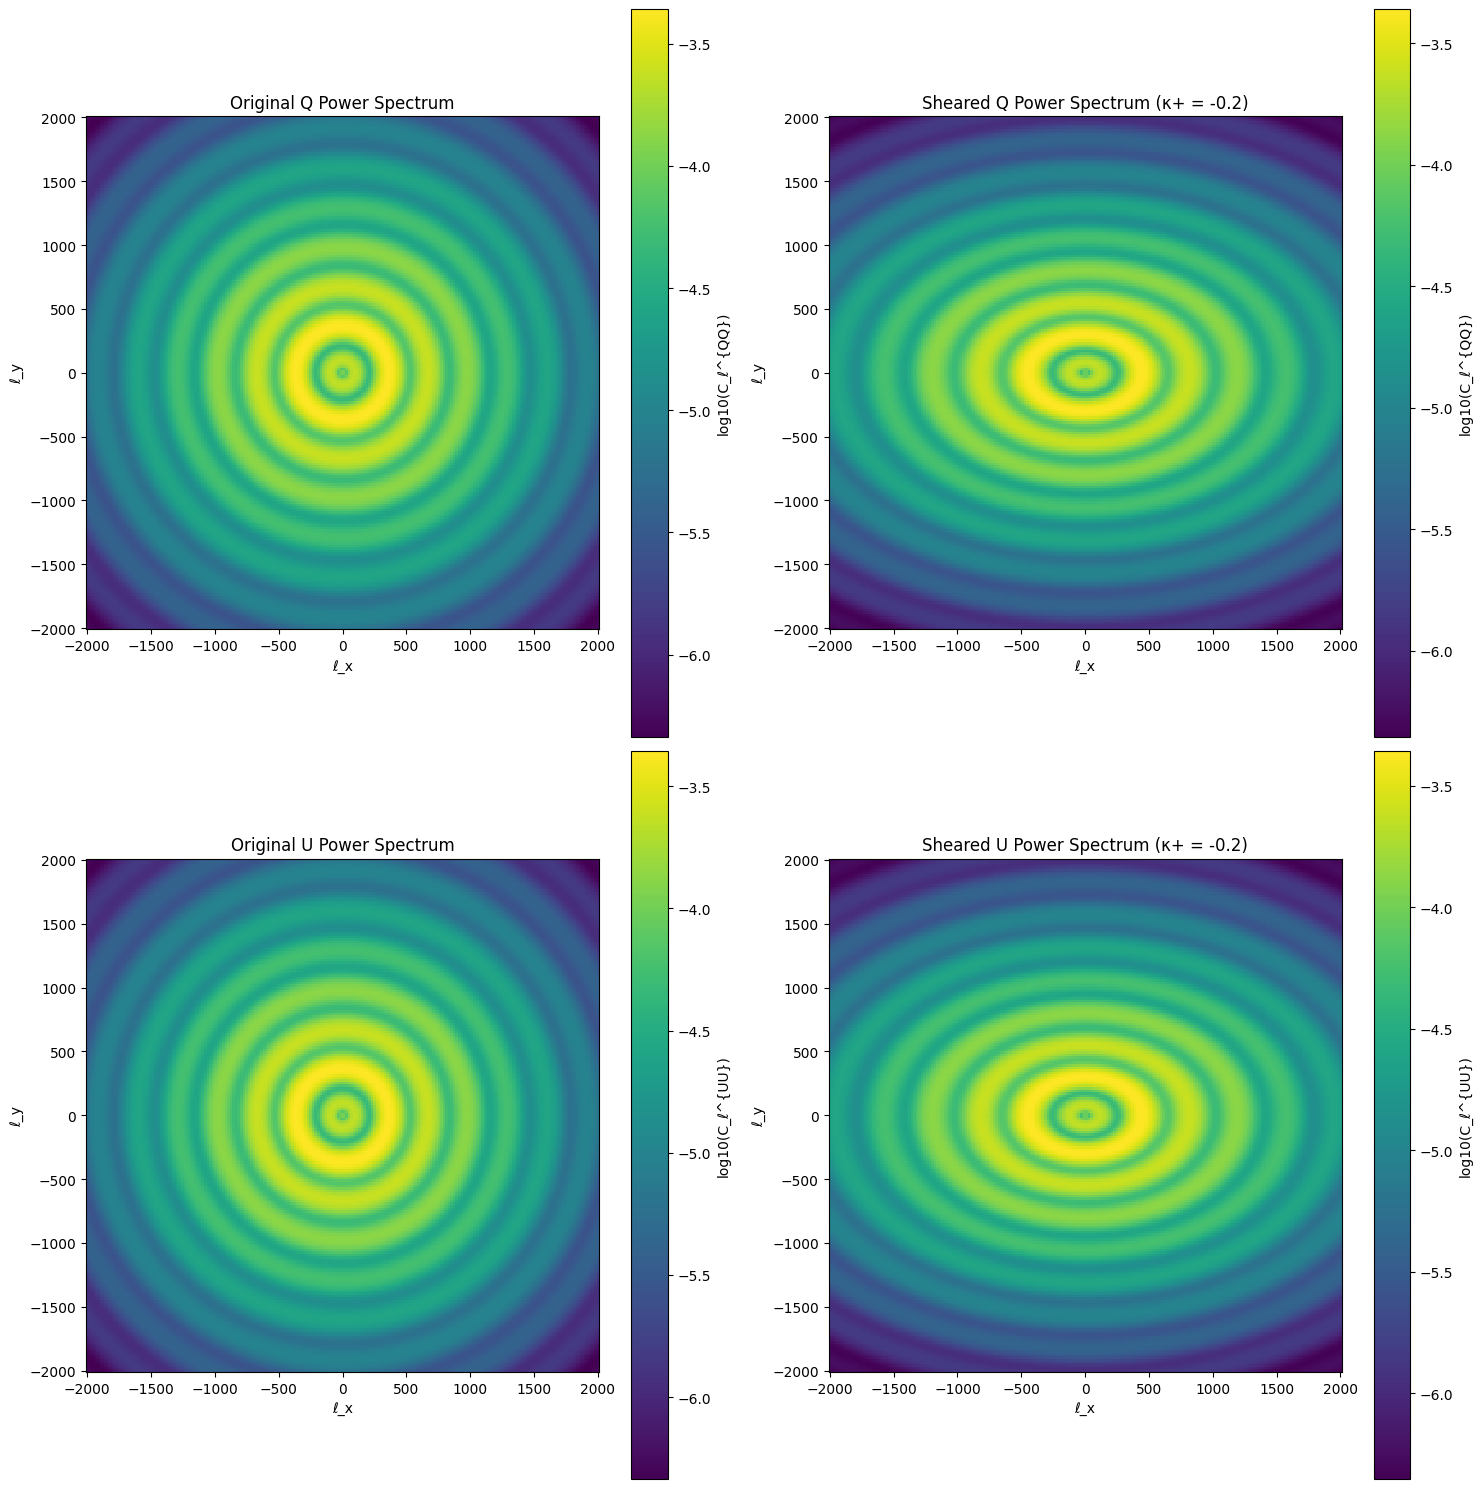

In [102]:
import numpy as np
import matplotlib.pyplot as plt

def get_QU_power(lx, ly):
    """
    Model for Q and U power spectra
    Q power has cos(2φ) dependence
    U power has sin(2φ) dependence in Fourier space
    """
    l = np.sqrt(lx**2 + ly**2)
    phi = np.arctan2(ly, lx)
    
    # Base power spectrum similar to E modes
    #base = 1e-5 * (l/200.0)**(-2) * np.exp(-l/2000) * (1 + 0.5*np.cos(l/200 - np.pi/4))
    
    # Q and U patterns in Fourier space
    #Q_power = base * np.cos(2*phi)**2
    #U_power = base * np.sin(2*phi)**2
    
    ls = np.arange(len(DlEE))
    return np.interp(l, ls, DlEE)/2, np.interp(l, ls, DlEE)/2

def apply_shear(lx, ly, kappa_plus):
    """
    Apply shear transformation in Fourier space
    """
    lx_new = np.exp(kappa_plus) * lx
    ly_new = np.exp(-kappa_plus) * ly
    return lx_new, ly_new

# Set up grid
lmax = 2000
nl = 200
l = np.linspace(-lmax, lmax, nl)
LX, LY = np.meshgrid(l, l)

# Compute original Q,U power spectra
Q_power, U_power = get_QU_power(LX, LY)

# Apply shear transformation
kappa_plus = -0.2
LX_sheared, LY_sheared = apply_shear(LX, LY, kappa_plus)
Q_power_sheared, U_power_sheared = get_QU_power(LX_sheared, LY_sheared)

# Create figure
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 15))

# Plot original Q power
im1 = ax1.pcolormesh(LX, LY, np.log10(Q_power), 
                     cmap='viridis',
                     shading='auto')
plt.colorbar(im1, ax=ax1, label='log10(C_ℓ^{QQ})')
ax1.set_xlabel('ℓ_x')
ax1.set_ylabel('ℓ_y')
ax1.set_title('Original Q Power Spectrum')

# Plot sheared Q power
im2 = ax2.pcolormesh(LX, LY, np.log10(Q_power_sheared), 
                     cmap='viridis',
                     shading='auto')
plt.colorbar(im2, ax=ax2, label='log10(C_ℓ^{QQ})')
ax2.set_xlabel('ℓ_x')
ax2.set_ylabel('ℓ_y')
ax2.set_title(f'Sheared Q Power Spectrum (κ+ = {kappa_plus})')

# Plot original U power
im3 = ax3.pcolormesh(LX, LY, np.log10(U_power), 
                     cmap='viridis',
                     shading='auto')
plt.colorbar(im3, ax=ax3, label='log10(C_ℓ^{UU})')
ax3.set_xlabel('ℓ_x')
ax3.set_ylabel('ℓ_y')
ax3.set_title('Original U Power Spectrum')

# Plot sheared U power
im4 = ax4.pcolormesh(LX, LY, np.log10(U_power_sheared), 
                     cmap='viridis',
                     shading='auto')
plt.colorbar(im4, ax=ax4, label='log10(C_ℓ^{UU})')
ax4.set_xlabel('ℓ_x')
ax4.set_ylabel('ℓ_y')
ax4.set_title(f'Sheared U Power Spectrum (κ+ = {kappa_plus})')

# Make plots square
for ax in [ax1, ax2, ax3, ax4]:
    ax.set_aspect('equal')

plt.tight_layout()
plt.show()